In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20 and AGN == "-"')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')


In [3]:
def Get_mass_track(field, galaxy, lmass):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))    
    #make mass track
    mt = np.cumsum(sfh[::-1]) * (lbt[1] - lbt[0])*1E9
    
    #put into lookback time
    mt = np.array(mt)[::-1]
    
    #rescale
    mt /= max(mt)
    mt *= 10**lmass
    return lbt, mt

def Get_tq(field, galaxy):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))
    lbt, mtk = Get_mass_track(field, galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])
    
    sSFR = np.log10(sfh/mtk)
    
    prop_t = lbt + cosmo.lookback_time(mdb.query('id == {}'.format(galaxy)).zgrism.values[0]).value
    prop_a = (cosmo.hubble_time.value - prop_t) * 1E9
    
    sf_lim = np.log10(1/prop_a)
    q_lim = np.log10(0.2/prop_a)
    
    sf_frm = sSFR - sf_lim
    q_frm = sSFR - q_lim
    
    tq = interp1d(sf_frm, prop_t)(0) - interp1d(q_frm,prop_t)(0)
    th = interp1d(q_frm,prop_a)(0)
    
    return np.array([tq,th*1E-9])


In [5]:
tq,th = Get_tq('GND', 21156)

np.log10(tq/th)

-1.1076025937550917

In [6]:
field = 'GND'
galaxy = 21156

In [7]:
lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))
lbt, mtk = Get_mass_track(field, galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])

In [8]:
prop_t = lbt + cosmo.lookback_time(mdb.query('id == {}'.format(galaxy)).zgrism.values[0]).value
prop_a = (cosmo.hubble_time.value - prop_t) * 1E9

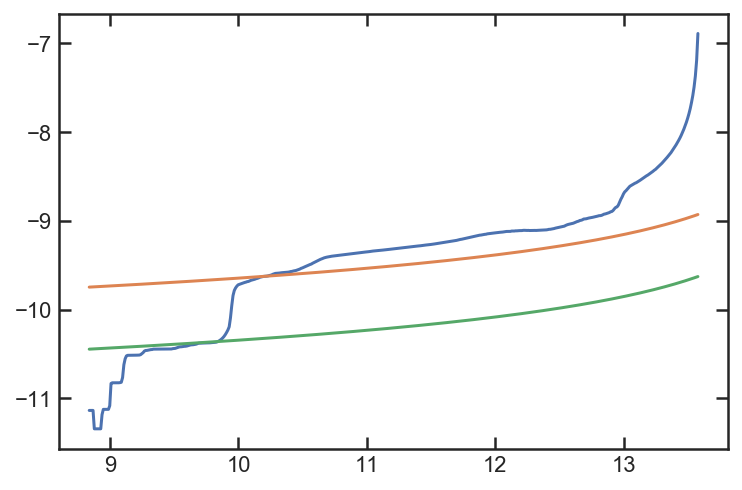

In [9]:
plt.plot(prop_t,np.log10(sfh/mtk))
# plt.xticks(cosmo.lookback_time([1.5,2,3,4,5,6,9]).value, [1.5,2,3,4,5,6,9] )
plt.plot(prop_t, np.log10(1/prop_a))
plt.plot(prop_t, np.log10(0.2/prop_a))
# plt.xlim(12,13)
# plt.ylim(-10.5, -9)
# plt.axvspan(12.395, 12.42, alpha = 0.2)
plt.minorticks_off()

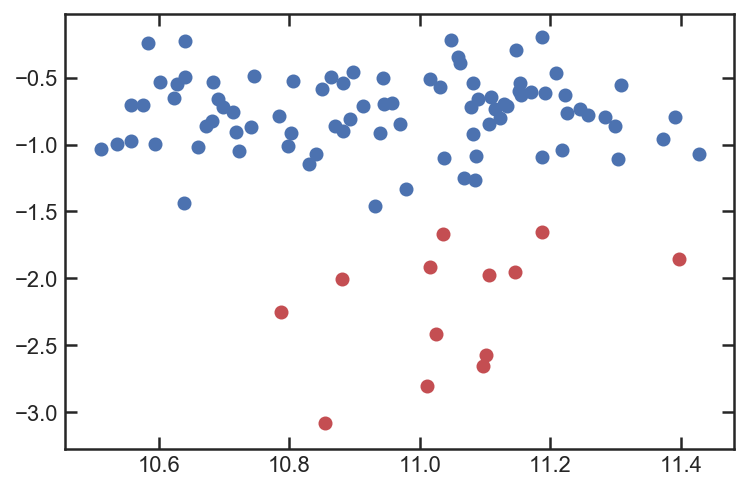

In [10]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.lmass[i] ,np.log10(tq/th),color = 'b')
#         plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.lmass[i] ,np.log10(tq/th),color = 'r')
#         plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th))   
# plt.axhline(-1.5)

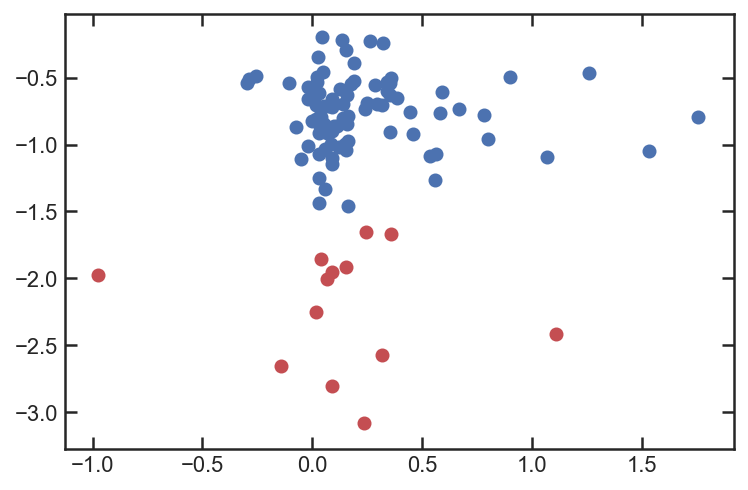

In [11]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.Re_f125[i] - mdb.Re_f160[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th))   
# plt.axhline(-1.5)

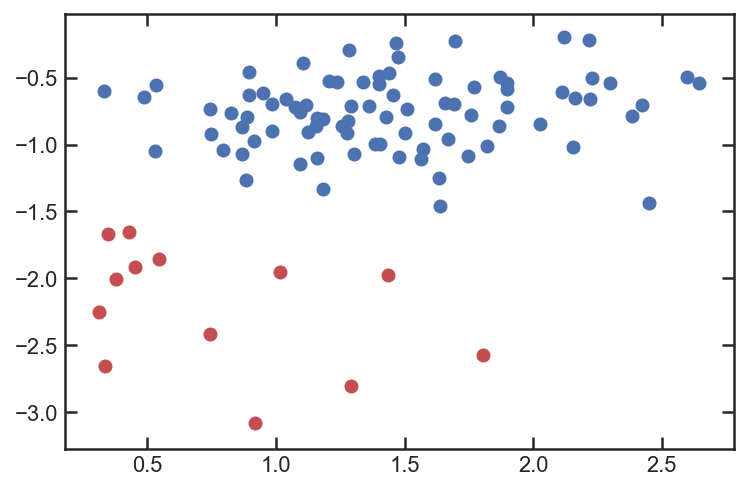

In [12]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.t_50[i] - mdb.t_90[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.t_50[i] - mdb.t_90[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 

(10.45, 9.4)

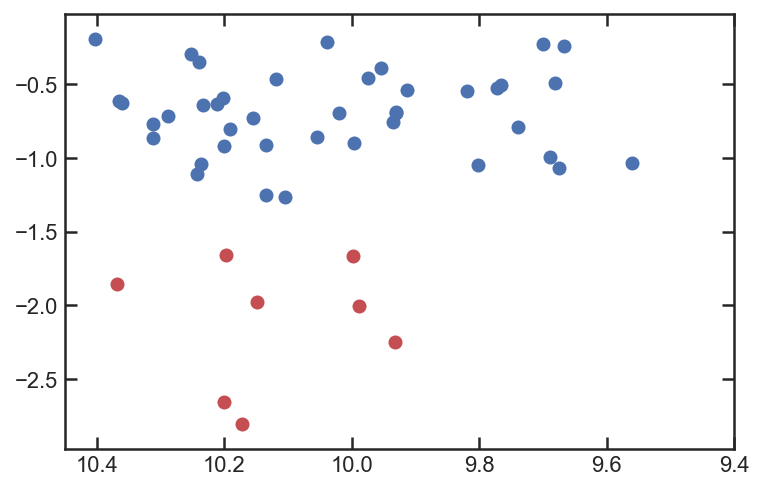

In [13]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 
plt.xlim(10.45,9.4)

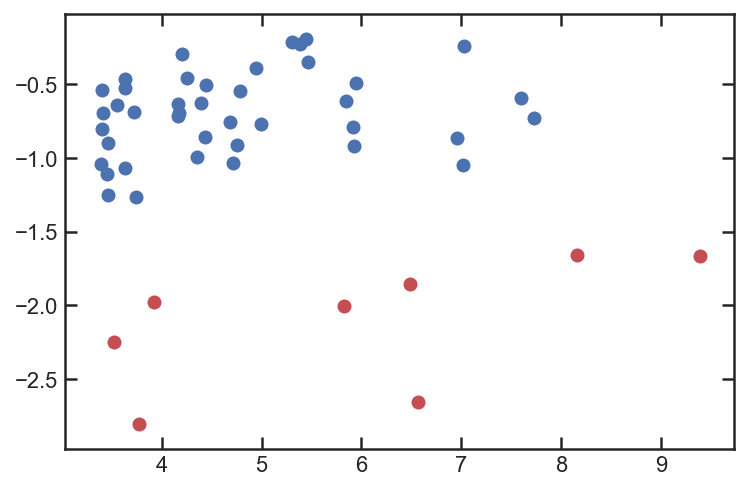

In [14]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.z_50[i] ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.z_50[i] ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 
# plt.axvline(3.4)

(10.45, 9.4)

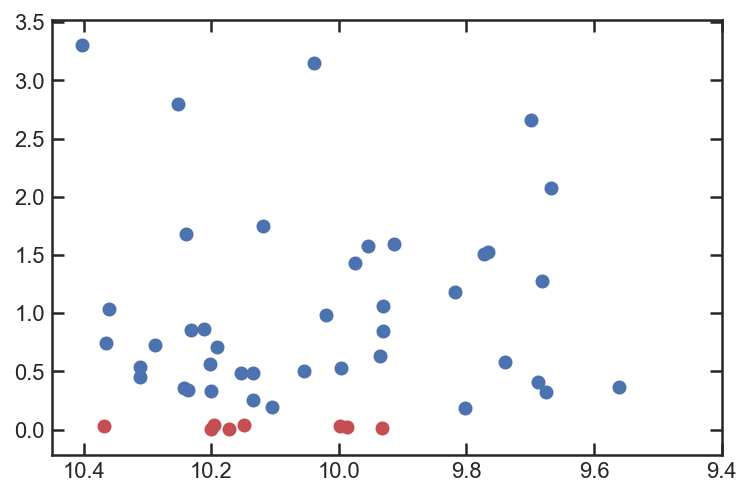

In [15]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,tq,color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,tq,color = 'r')
    trk.append(np.log10(tq/th)) 
plt.xlim(10.45,9.4)

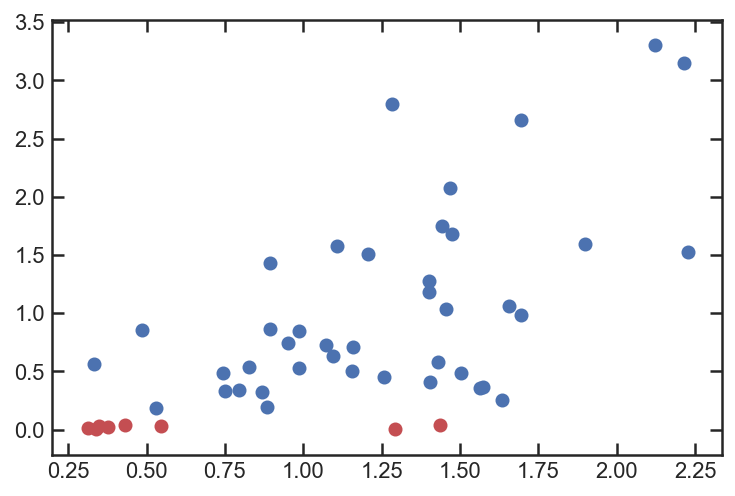

In [16]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(mdb.t_50[i] - mdb.t_90[i] ,tq,color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(mdb.t_50[i] - mdb.t_90[i] ,tq,color = 'r')
    trk.append(np.log10(tq/th)) 


In [10]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)
    ################

    stack = np.zeros(len(lbt))
    for i in range(len(lbt)):
        weights = len(sfhgrid[i][sfhgrid[i] > 0])
        
#         stack[i] = np.sum(sfhgrid[i]) / (weights)       
        stack[i] = np.mean(sfhgrid[i])# / (weights)        
        
    ################
    
    return stack

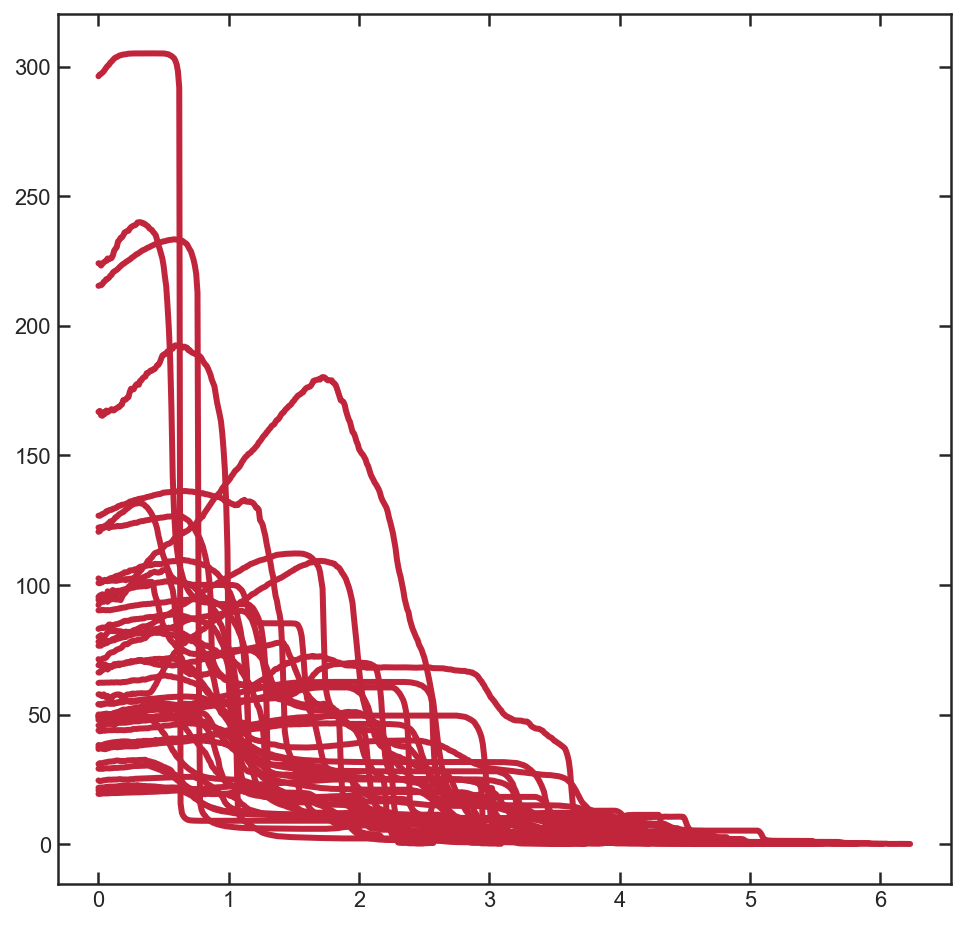

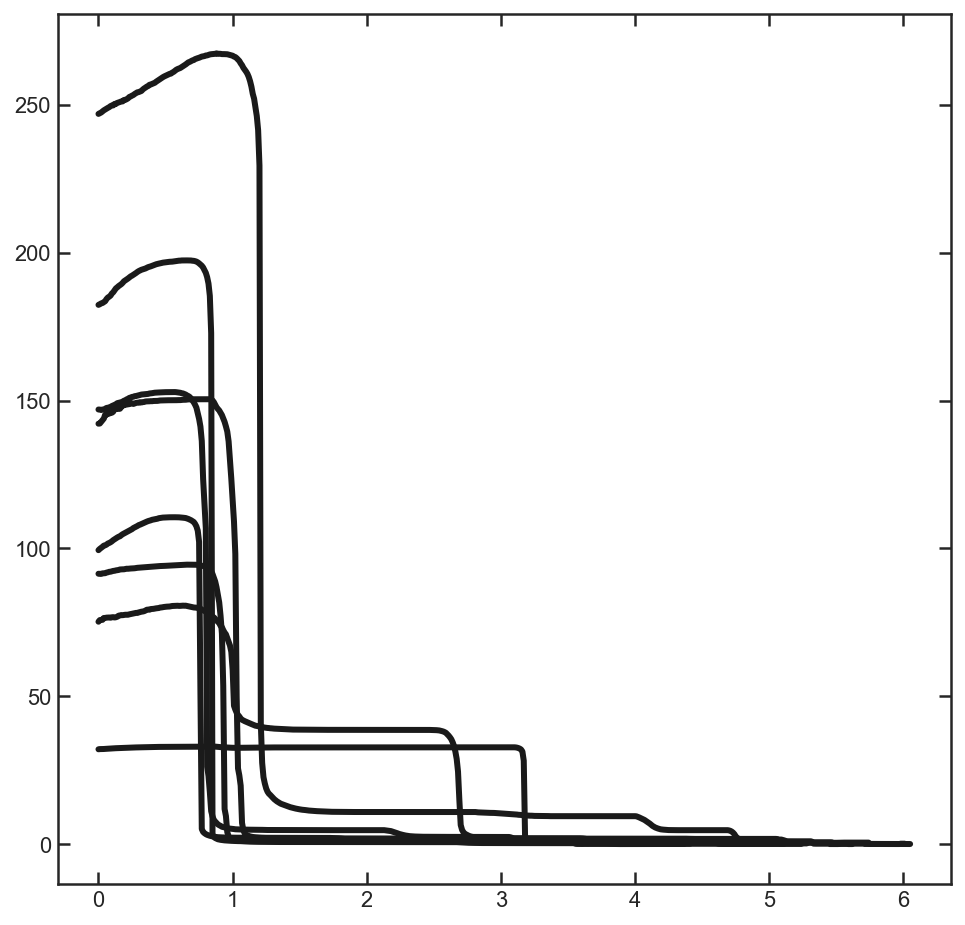

In [17]:
plt.figure(figsize =[8,8])

LBT_lz = []
SFH_lz = []
for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    field = mdb.field[i]
    galaxy = mdb.id[i]
    if np.log10(tq/th) > -1.5:  

    
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(field, galaxy))
        LBT_lz.append(lbt)
        SFH_lz.append(sfh[::-1] / 10**mdb.lmass[i])
#         SFH_lz.append(sfh[::-1])

        plt.plot(lbt, sfh[::-1], color = '#C1253C', linewidth = 3, zorder = 9)

plt.figure(figsize =[8,8])
LBT_hz = []
SFH_hz = []
for i in Smdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    field = mdb.field[i]
    galaxy = mdb.id[i]
    if np.log10(tq/th) < -1.5:  
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(field, galaxy))
        LBT_hz.append(lbt)
        SFH_hz.append(sfh[::-1] / 10**mdb.lmass[i])
#         SFH_hz.append(sfh[::-1])

        plt.plot(lbt, sfh[::-1], color = 'k', linewidth = 3, zorder = 9)

In [18]:
LBT = np.linspace(0,7,7000)

SFH_lzgrid = np.zeros([len(LBT_lz), len(LBT)])

for i in range(len(LBT_lz)):
    SFH_lzgrid[i] = interp1d(LBT_lz[i], SFH_lz[i], fill_value=0, bounds_error=False)(LBT)

sfh_stack_lz = Stack_SFH(LBT, SFH_lzgrid)

SFH_hzgrid = np.zeros([len(LBT_hz), len(LBT)])

for i in range(len(LBT_hz)):
    SFH_hzgrid[i] = interp1d(LBT_hz[i], SFH_hz[i], fill_value=0, bounds_error=False)(LBT)

sfh_stack_hz = Stack_SFH(LBT, SFH_hzgrid)

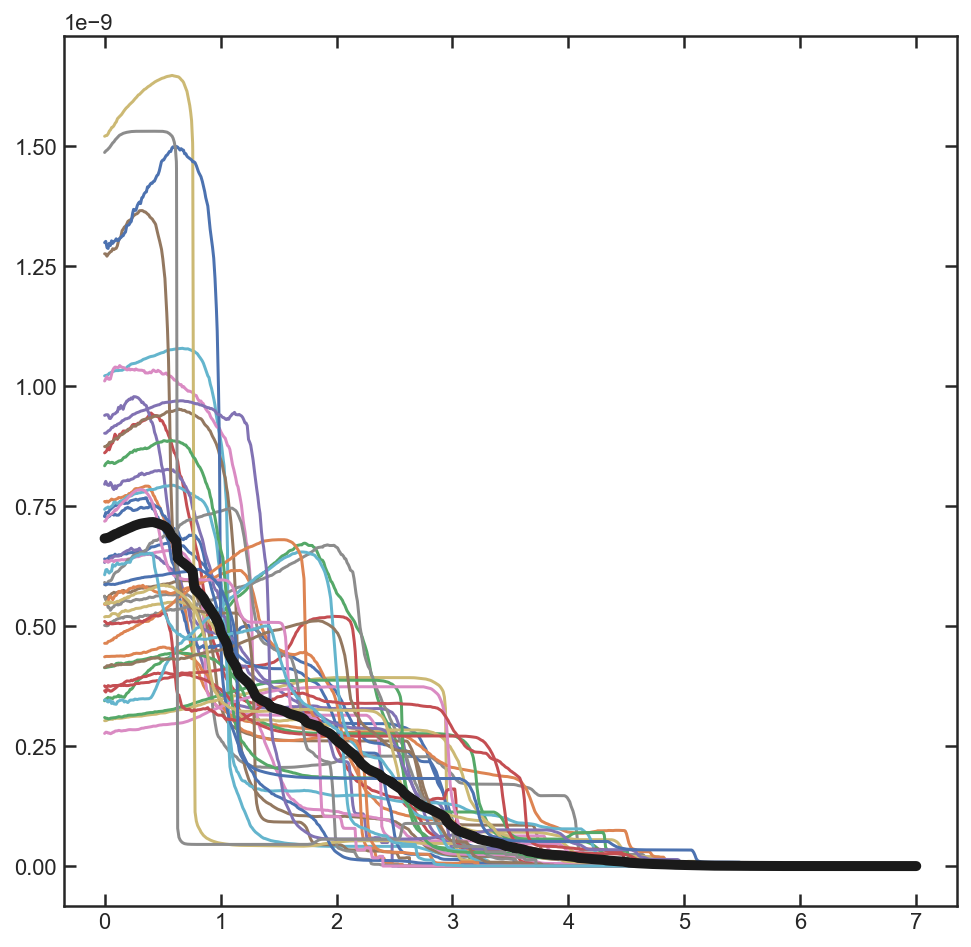

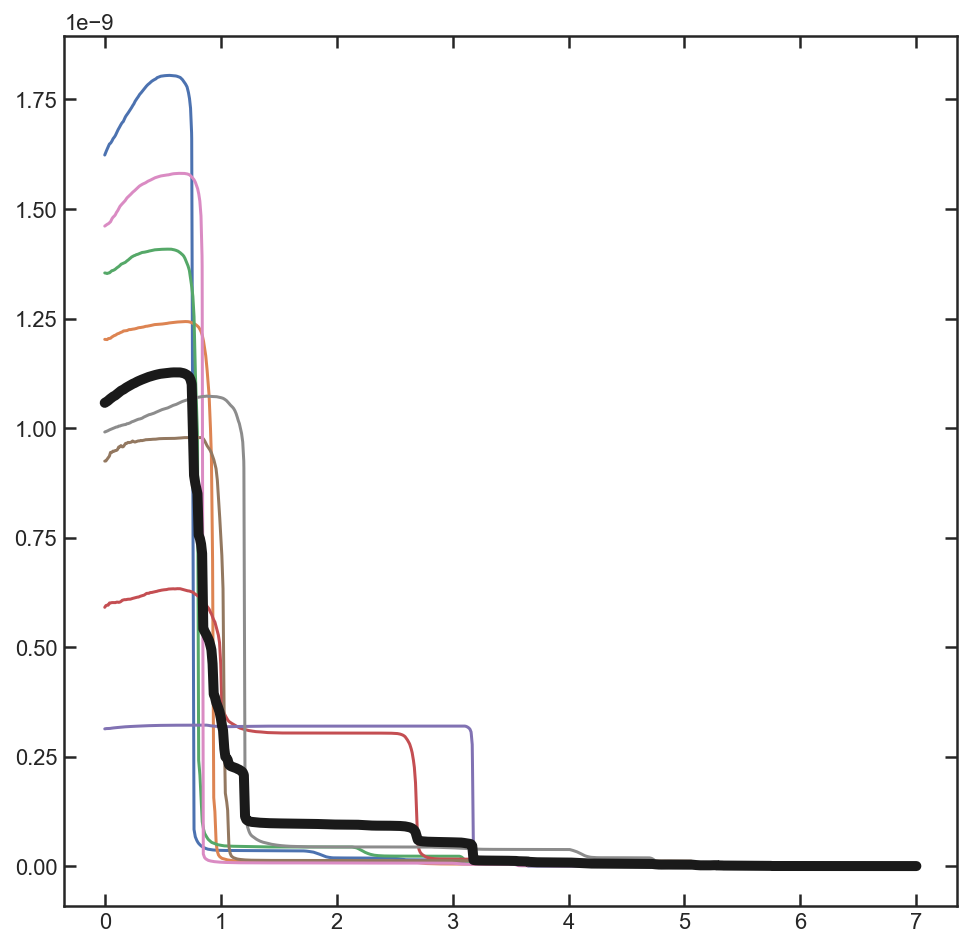

In [19]:
plt.figure(figsize=[8,8])

plt.plot(LBT, SFH_lzgrid.T)
plt.plot(LBT, sfh_stack_lz, 'k', linewidth = 5)

plt.figure(figsize=[8,8])

plt.plot(LBT, SFH_hzgrid.T)
plt.plot(LBT, sfh_stack_hz, 'k', linewidth = 5)

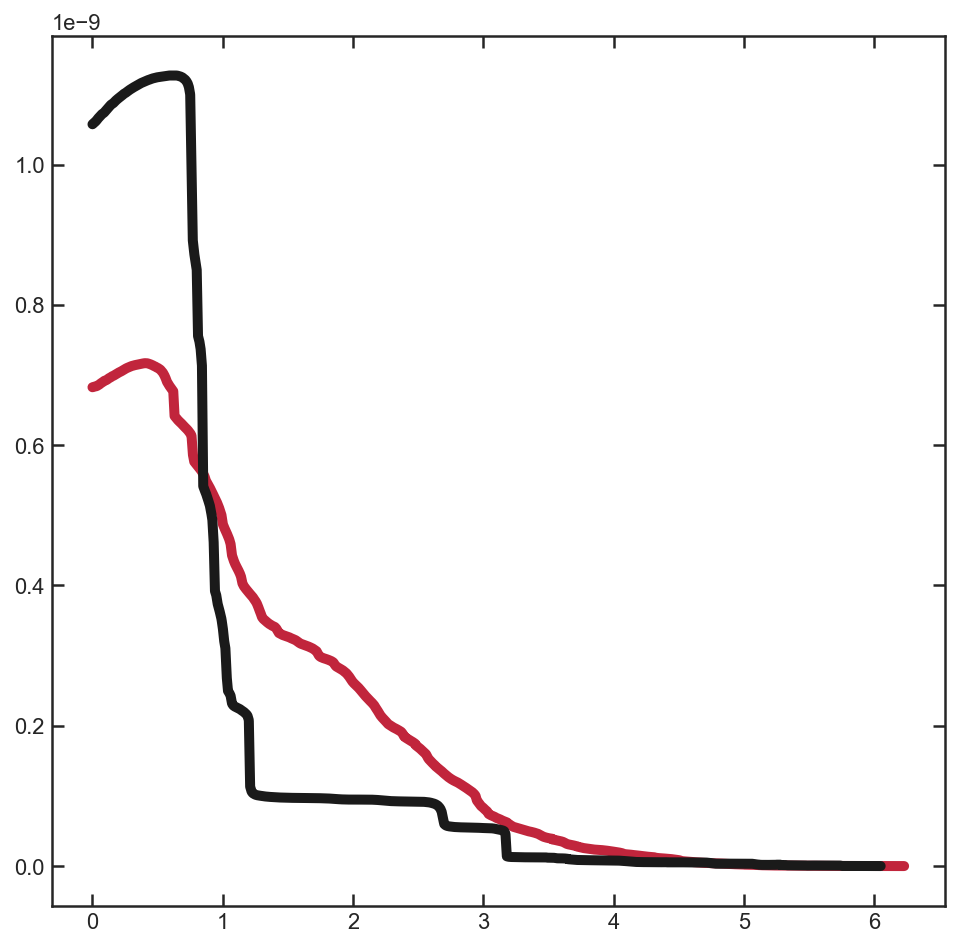

In [20]:
plt.figure(figsize =[8,8])

plt.plot(LBT[sfh_stack_lz > 0], sfh_stack_lz[sfh_stack_lz > 0], '#C1253C', linewidth = 5)
plt.plot(LBT[sfh_stack_hz > 0], sfh_stack_hz[sfh_stack_hz > 0], 'k', linewidth = 5)

In [32]:
field = 'GND'
galaxy = 17070
lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field,galaxy))
L, MT = Get_mass_track(field,galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])

In [29]:
lbg = np.loadtxt('../data/plot_points/points2.csv').T
smg = np.loadtxt('../data/plot_points/points1.csv').T
hdrp = np.loadtxt('../data/plot_points/points3.csv').T

In [30]:
l = np.loadtxt('../data/plot_points/points4.csv').T
ler1 = np.loadtxt('../data/plot_points/points5.csv').T
ler2 = np.loadtxt('../data/plot_points/points6.csv').T

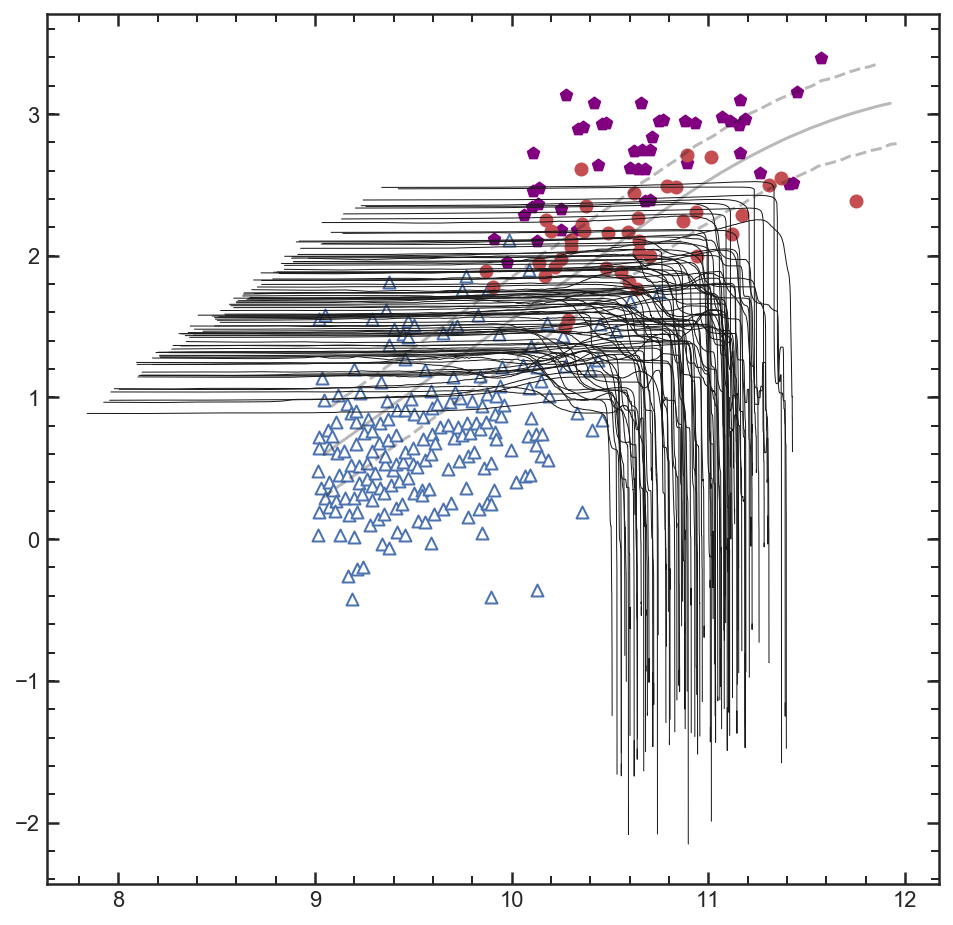

In [36]:
plt.figure(figsize=[8,8])

for i in mdb.index:
    field = mdb.field[i]
    galaxy = mdb.id[i]
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field,galaxy))
    L, MT = Get_mass_track(field,galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])
    
    plt.plot(np.log10(MT), np.log10(sfh),'k', linewidth = 0.5)

plt.scatter(lbg[0], lbg[1], marker = '^', edgecolors='b', color = 'w')
plt.scatter(smg[0], smg[1], marker = 'p', color = 'purple')
plt.scatter(hdrp[0], hdrp[1],color = 'r')

    
plt.plot(l[0],l[1], 'k', alpha = 0.3, )
plt.plot(ler1[0],ler1[1], 'k--', alpha = 0.3, )
plt.plot(ler2[0],ler2[1], 'k--', alpha = 0.3, )

